In [1]:
!hdfs dfs -put train.csv /user/$USER

put: `/user/ana007588/train.csv': File exists


In [2]:
!hdfs dfs -ls /user/$USER

Found 6 items
drwxr-xr-x   - ana007588 supergroup          0 2023-06-27 15:15 /user/ana007588/.sparkStaging
drwxr-xr-x   - ana007588 supergroup          0 2023-06-24 13:22 /user/ana007588/datasets
drwxr-xr-x   - ana007588 supergroup          0 2023-06-12 15:21 /user/ana007588/demo_dir
-rw-r--r--   3 ana007588 supergroup    9598228 2023-06-24 13:38 /user/ana007588/test.csv
-rw-r--r--   3 ana007588 supergroup   25525678 2023-06-24 13:38 /user/ana007588/train.csv
-rw-r--r--   3 ana007588 supergroup        424 2023-06-24 01:56 /user/ana007588/users_01.dat


In [3]:
# importing the required libraries
from pyspark.sql import SparkSession
import pyspark.sql.types as tp
from pyspark.sql import functions as F

# libraries to make plots
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# creating spark session
spark = SparkSession.builder.getOrCreate()
print(type(spark))

/home/ana007588/.local/lib/python3.6/site-packages/pyspark/context.py:238: FutureWarning: Python 3.6 support is deprecated in Spark 3.2.
  FutureWarning


<class 'pyspark.sql.session.SparkSession'>


In [5]:
# reading the training data
train_data = spark.read.csv("train.csv",inferSchema=True, header=True)

In [6]:
print(type(train_data))

<class 'pyspark.sql.dataframe.DataFrame'>


In [7]:
train_data.show()

+---+-----+--------------------+
| id|label|               tweet|
+---+-----+--------------------+
|  1|    0| @user when a fat...|
|  2|    0|@user @user thank...|
|  3|    0|  bihday your maj...|
|  4|    0|#model   i love u...|
|  5|    0| factsguide: soci...|
|  6|    0|[2/2] huge fan fa...|
|  7|    0| @user camping to...|
|  8|    0|the next school y...|
|  9|    0|we won!!! love th...|
| 10|    0| @user @user welc...|
| 11|    0| â #ireland con...|
| 12|    0|we are so selfish...|
| 13|    0|i get to see my d...|
| 14|    1|@user #cnn calls ...|
| 15|    1|no comment!  in #...|
| 16|    0|ouch...junior is ...|
| 17|    0|i am thankful for...|
| 18|    1|retweet if you ag...|
| 19|    0|its #friday! ð...|
| 20|    0|as we all know, e...|
+---+-----+--------------------+
only showing top 20 rows



In [8]:
# shape of dataframe
print("Training Data: ({},{})".format(train_data.count(), len(train_data.columns)))

Training Data: (31962,3)


There are 31962 rows in the training data.

In [9]:
train_data.collect()[0][2]

' @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run'

In [10]:
train_data.columns

['id', 'label', 'tweet']

In [11]:
# datatypes
train_data.printSchema()

root
 |-- id: integer (nullable = true)
 |-- label: integer (nullable = true)
 |-- tweet: string (nullable = true)



In [12]:
# checking for null values
for c in train_data.columns:
    # define the condition
    missing_values = F.isnull(c)
    
    # filter the data with condition and count the number of data points
    missing_values = train_data.filter(missing_values).count()
    
    # print the result
    print(c, missing_values)

id 0
label 0
tweet 0


There are no null values present in the given data.

In [13]:
# counting the distinct values in each column
for c in train_data.columns:
    print(c,"has " ,train_data.select(F.col(c)).distinct().count(), " distinct values")

id has  31962  distinct values
label has  2  distinct values
tweet has  29528  distinct values


1. There are 31962 unique values in the id, which means it is specific to each row, hence will not contribute any meaning to the model.
2. There are only 2 distinct values in label column, means there are only 2 categories of labels.
3. There are only 29528 unique tweets, which is less than the total number of rows. This indicate there are duplicate tweets as well in the dataset. So let's check for these. 

In [14]:
train_data \
    .groupby(["tweet"]) \
    .count() \
    .where('count > 1') \
    .sort('count', ascending=False) \
    .show() 

+--------------------+-----+
|               tweet|count|
+--------------------+-----+
|#model   i love u...|  319|
|i finally found a...|   82|
|aww yeah it's all...|   75|
|i'm so   and #gra...|   56|
|@user you might b...|   40|
|you might be a li...|   32|
|ð #love #insta...|   29|
|have my lover sto...|   26|
|"#flagday2016   #...|   22|
|get #up get   get...|   21|
|#sikh #temple van...|   20|
|@user #feminismis...|   20|
|save $$ no logins...|   17|
|can #lighttherapy...|   16|
|best essential oi...|   14|
|#music as #therap...|   14|
|what is a #detoxd...|   14|
|does #magnetthera...|   14|
|can #lighttherapy...|   14|
|best #essentialoi...|   14|
+--------------------+-----+
only showing top 20 rows



In [15]:
# checking for distribution of data
train_data.groupBy("label").agg(F.count("label").alias("count"),
                                             F.round((F.count("label")/train_data.count())*100, 4).alias("percentage")).show()

+-----+-----+----------+
|label|count|percentage|
+-----+-----+----------+
|    1| 2242|    7.0146|
|    0|29720|   92.9854|
+-----+-----+----------+



The dataset is highly imbalanced.

In [16]:
# checking
train_data.select(F.size(F.split(F.col("tweet"), " "))).show()

+-------------------------+
|size(split(tweet,  , -1))|
+-------------------------+
|                       21|
|                       22|
|                        5|
|                       17|
|                        8|
|                       21|
|                       12|
|                       23|
|                       13|
|                       15|
|                       21|
|                       16|
|                       11|
|                       14|
|                       13|
|                        9|
|                       14|
|                        5|
|                       16|
|                       12|
+-------------------------+
only showing top 20 rows



In [17]:
# counting the length of the tweet
train_data = train_data.withColumn("len_tweet",F.length(F.col("tweet")))

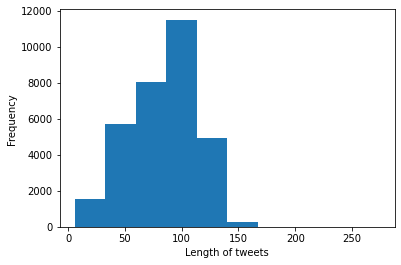

In [18]:
# plotting
plot = train_data.toPandas()
plt.hist(plot['len_tweet'])
plt.xlabel("Length of tweets")
plt.ylabel("Frequency")
plt.show()

In [19]:
# counting the number of words in a tweet
train_data = train_data.withColumn("word_count",F.size(F.split(F.col("tweet"), " ")))

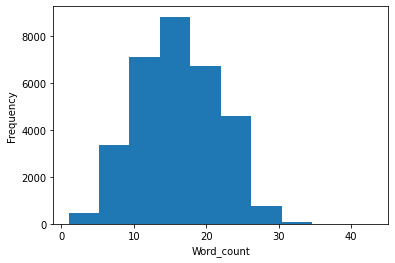

In [20]:
# plotting
plot = train_data.toPandas()
plt.hist(plot['word_count'])
plt.xlabel("Word_count")
plt.ylabel("Frequency")
plt.show()

In [21]:
# checking the distribution of labels
plot['label'].value_counts()/ len(plot['label'])

0    0.929854
1    0.070146
Name: label, dtype: float64

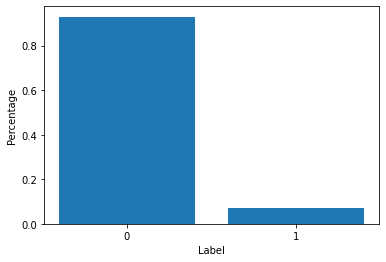

In [22]:
plt.bar(['0', '1'], plot['label'].value_counts()/ len(plot['label']))
plt.xlabel("Label")
plt.ylabel("Percentage")
plt.show()

In [23]:
train_data.printSchema()

root
 |-- id: integer (nullable = true)
 |-- label: integer (nullable = true)
 |-- tweet: string (nullable = true)
 |-- len_tweet: integer (nullable = true)
 |-- word_count: integer (nullable = false)



# Text Preprocessing

In [24]:
# clean tweets
train_data = train_data.withColumn("tidy", (F.lower(F.regexp_replace('tweet', "@[\w]*", ""))))  # removing username
train_data = train_data.withColumn("tidy", (F.lower(F.regexp_replace('tidy', "[^ a-zA-Z#]", ""))))  # removing punctuation and special characters

In [25]:
train_data.show()

+---+-----+--------------------+---------+----------+--------------------+
| id|label|               tweet|len_tweet|word_count|                tidy|
+---+-----+--------------------+---------+----------+--------------------+
|  1|    0| @user when a fat...|      102|        21|  when a father i...|
|  2|    0|@user @user thank...|      122|        22|  thanks for #lyf...|
|  3|    0|  bihday your maj...|       21|         5|  bihday your maj...|
|  4|    0|#model   i love u...|       86|        17|#model   i love u...|
|  5|    0| factsguide: soci...|       39|         8| factsguide socie...|
|  6|    0|[2/2] huge fan fa...|      116|        21| huge fan fare an...|
|  7|    0| @user camping to...|       74|        12|  camping tomorro...|
|  8|    0|the next school y...|      143|        23|the next school y...|
|  9|    0|we won!!! love th...|       87|        13|we won love the l...|
| 10|    0| @user @user welc...|       50|        15|   welcome here  ...|
| 11|    0| â #ireland 

In [26]:
#pip install nltk

In [27]:
# importing required libraries
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import PorterStemmer
from pyspark.sql.types import *
from pyspark.sql.functions import udf, col, lower, regexp_replace

In [28]:
# Tokenize tweets
tokenizer = Tokenizer(inputCol='tidy', outputCol='words_token')
df_words_token = tokenizer.transform(train_data).select('id', 'words_token')

In [29]:
df_words_token.show()

+---+--------------------+
| id|         words_token|
+---+--------------------+
|  1|[, , when, a, fat...|
|  2|[, , thanks, for,...|
|  3|[, , bihday, your...|
|  4|[#model, , , i, l...|
|  5|[, factsguide, so...|
|  6|[, huge, fan, far...|
|  7|[, , camping, tom...|
|  8|[the, next, schoo...|
|  9|[we, won, love, t...|
| 10|[, , , welcome, h...|
| 11|[, , #ireland, co...|
| 12|[we, are, so, sel...|
| 13|[i, get, to, see,...|
| 14|[, #cnn, calls, #...|
| 15|[no, comment, , i...|
| 16|[ouchjunior, is, ...|
| 17|[i, am, thankful,...|
| 18|[retweet, if, you...|
| 19|[its, #friday, , ...|
| 20|[as, we, all, kno...|
+---+--------------------+
only showing top 20 rows



In [30]:
# Remove stop words
remover = StopWordsRemover(inputCol='words_token', outputCol='words_clean')
df_words_no_stopw = remover.transform(df_words_token).select('id', 'words_clean')

In [31]:
df_words_no_stopw.show()

+---+--------------------+
| id|         words_clean|
+---+--------------------+
|  1|[, , father, dysf...|
|  2|[, , thanks, #lyf...|
|  3|[, , bihday, maje...|
|  4|[#model, , , love...|
|  5|[, factsguide, so...|
|  6|[, huge, fan, far...|
|  7|[, , camping, tom...|
|  8|[next, school, ye...|
|  9|[won, love, land,...|
| 10|[, , , welcome, ,...|
| 11|[, , #ireland, co...|
| 12|[selfish, #orland...|
| 13|[get, see, daddy,...|
| 14|[, #cnn, calls, #...|
| 15|[comment, , #aust...|
| 16|[ouchjunior, angr...|
| 17|[thankful, paner,...|
| 18|    [retweet, agree]|
| 19|[#friday, , smile...|
| 20|[know, essential,...|
+---+--------------------+
only showing top 20 rows



In [32]:
#pip install -U regex

In [33]:
# Stem tweets
stemmer = PorterStemmer()
stemmer_udf = F.udf(lambda tokens: [stemmer.stem(token) for token in tokens], ArrayType(StringType()))
df_stemmed = df_words_no_stopw.withColumn("words_stemmed", stemmer_udf("words_clean")).select('id', 'words_stemmed')

In [34]:
df_stemmed.show()

+---+--------------------+
| id|       words_stemmed|
+---+--------------------+
|  1|[, , father, dysf...|
|  2|[, , thank, #lyft...|
|  3|[, , bihday, maje...|
|  4|[#model, , , love...|
|  5|[, factsguid, soc...|
|  6|[, huge, fan, far...|
|  7|[, , camp, tomorr...|
|  8|[next, school, ye...|
|  9|[won, love, land,...|
| 10|[, , , welcom, , ...|
| 11|[, , #ireland, co...|
| 12|[selfish, #orland...|
| 13|[get, see, daddi,...|
| 14|[, #cnn, call, #m...|
| 15|[comment, , #aust...|
| 16|[ouchjunior, angr...|
| 17|[thank, paner, #t...|
| 18|     [retweet, agre]|
| 19|[#friday, , smile...|
| 20|[know, essenti, o...|
+---+--------------------+
only showing top 20 rows



In [35]:
# Filter length word > 3
filter_length_udf = F.udf(lambda row: [x for x in row if len(x) >= 3], ArrayType(StringType()))
df_final_words = df_stemmed.withColumn('words', filter_length_udf(col('words_stemmed')))

In [36]:
df_final_words.show()

+---+--------------------+--------------------+
| id|       words_stemmed|               words|
+---+--------------------+--------------------+
|  1|[, , father, dysf...|[father, dysfunct...|
|  2|[, , thank, #lyft...|[thank, #lyft, cr...|
|  3|[, , bihday, maje...|   [bihday, majesti]|
|  4|[#model, , , love...|[#model, love, ta...|
|  5|[, factsguid, soc...|[factsguid, socie...|
|  6|[, huge, fan, far...|[huge, fan, fare,...|
|  7|[, , camp, tomorr...|[camp, tomorrow, ...|
|  8|[next, school, ye...|[next, school, ye...|
|  9|[won, love, land,...|[won, love, land,...|
| 10|[, , , welcom, , ...|       [welcom, #gr]|
| 11|[, , #ireland, co...|[#ireland, consum...|
| 12|[selfish, #orland...|[selfish, #orland...|
| 13|[get, see, daddi,...|[get, see, daddi,...|
| 14|[, #cnn, call, #m...|[#cnn, call, #mic...|
| 15|[comment, , #aust...|[comment, #austra...|
| 16|[ouchjunior, angr...|[ouchjunior, angr...|
| 17|[thank, paner, #t...|[thank, paner, #t...|
| 18|     [retweet, agre]|     [retweet,

In [37]:
df = df_final_words.select('id','words')
df.show()

+---+--------------------+
| id|               words|
+---+--------------------+
|  1|[father, dysfunct...|
|  2|[thank, #lyft, cr...|
|  3|   [bihday, majesti]|
|  4|[#model, love, ta...|
|  5|[factsguid, socie...|
|  6|[huge, fan, fare,...|
|  7|[camp, tomorrow, ...|
|  8|[next, school, ye...|
|  9|[won, love, land,...|
| 10|       [welcom, #gr]|
| 11|[#ireland, consum...|
| 12|[selfish, #orland...|
| 13|[get, see, daddi,...|
| 14|[#cnn, call, #mic...|
| 15|[comment, #austra...|
| 16|[ouchjunior, angr...|
| 17|[thank, paner, #t...|
| 18|     [retweet, agre]|
| 19|[#friday, smile, ...|
| 20|[know, essenti, o...|
+---+--------------------+
only showing top 20 rows



In [38]:
train_data = train_data.join(df, on= 'id', how='inner')

In [39]:
train_data.show()

+---+-----+--------------------+---------+----------+--------------------+--------------------+
| id|label|               tweet|len_tweet|word_count|                tidy|               words|
+---+-----+--------------------+---------+----------+--------------------+--------------------+
|  1|    0| @user when a fat...|      102|        21|  when a father i...|[father, dysfunct...|
|  2|    0|@user @user thank...|      122|        22|  thanks for #lyf...|[thank, #lyft, cr...|
|  3|    0|  bihday your maj...|       21|         5|  bihday your maj...|   [bihday, majesti]|
|  4|    0|#model   i love u...|       86|        17|#model   i love u...|[#model, love, ta...|
|  5|    0| factsguide: soci...|       39|         8| factsguide socie...|[factsguid, socie...|
|  6|    0|[2/2] huge fan fa...|      116|        21| huge fan fare an...|[huge, fan, fare,...|
|  7|    0| @user camping to...|       74|        12|  camping tomorro...|[camp, tomorrow, ...|
|  8|    0|the next school y...|      14

In [40]:
train_data.printSchema()

root
 |-- id: integer (nullable = true)
 |-- label: integer (nullable = true)
 |-- tweet: string (nullable = true)
 |-- len_tweet: integer (nullable = true)
 |-- word_count: integer (nullable = false)
 |-- tidy: string (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [41]:
from pyspark.ml.feature import Word2Vec

#create an average word vector for each document
word2vec = Word2Vec(vectorSize = 50, minCount = 5, inputCol = 'words', outputCol = 'result', seed = 7)
model = word2vec.fit(train_data)
result = model.transform(train_data)

result.show(10)


+---+-----+--------------------+---------+----------+--------------------+--------------------+--------------------+
| id|label|               tweet|len_tweet|word_count|                tidy|               words|              result|
+---+-----+--------------------+---------+----------+--------------------+--------------------+--------------------+
|  1|    0| @user when a fat...|      102|        21|  when a father i...|[father, dysfunct...|[-0.1125749397490...|
|  2|    0|@user @user thank...|      122|        22|  thanks for #lyf...|[thank, #lyft, cr...|[-0.0416154510055...|
|  3|    0|  bihday your maj...|       21|         5|  bihday your maj...|   [bihday, majesti]|[-0.1852476615458...|
|  4|    0|#model   i love u...|       86|        17|#model   i love u...|[#model, love, ta...|[-0.3600467555224...|
|  5|    0| factsguide: soci...|       39|         8| factsguide socie...|[factsguid, socie...|[0.03921172146995...|
|  6|    0|[2/2] huge fan fa...|      116|        21| huge fan f

In [42]:
# importing the libraries
from pyspark.ml import classification
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [43]:
# splitting the data into training and validation sets
train_cv, valid_cv = result.randomSplit([0.7, 0.3], seed= 9)

In [44]:
# defining logistic regression model
model_LR = classification.LogisticRegression(featuresCol="result", labelCol="label")

In [45]:
model_LR = model_LR.fit(train_cv)

In [46]:
# Evaluate training data
evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC") 
evaluator.evaluate(model_LR.transform(train_cv)) 

0.8557614673656221

In [47]:
evaluator.evaluate(model_LR.transform(valid_cv))

0.8536711946288088

As the training data is highly imbalanced, area under ROC is not a good measure to evaluate, hence checking area under PR curve also

In [48]:
# Evaluate training data
evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderPR") 
evaluator.evaluate(model_LR.transform(train_cv)) 

0.4016919627618745

In [49]:
evaluator.evaluate(model_LR.transform(valid_cv))

0.40662287938577585

In [50]:
# importing the CrossValidator and ParamGridBuilder
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [51]:
# create the object of the Logistic Regression Model
model_LR_CV = classification.LogisticRegression(featuresCol= "result",  labelCol="label")

In [52]:

updated_params = ParamGridBuilder() \
                .addGrid(model_LR_CV.regParam, [0.01, 0.005, 0.0001]) \
                .addGrid(model_LR_CV.elasticNetParam, [0.1, 0.001]) \
                .build()

In [53]:
# create object of the Cross Calidator with 3 folds
cv = CrossValidator(estimator=model_LR_CV,
                    estimatorParamMaps=updated_params,
                    evaluator=evaluator,
                    numFolds=3,
                    seed=27)

In [54]:
grid_model = cv.fit(result)

In [55]:
# evaluate the model
evaluator = BinaryClassificationEvaluator(labelCol="label",metricName="areaUnderROC") 
evaluator.evaluate(grid_model.transform(result))

0.8465198903713883

In [56]:
# Evaluate training data
evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderPR") 
evaluator.evaluate(model_LR.transform(result)) 

0.40255563577342035

In [57]:
# extract the best model parameters dictionary
param_dict = grid_model.bestModel.extractParamMap()
# created a filtered dictionary
final_dict = {}
for k, v in param_dict.items():
    final_dict[k.name] = v

In [58]:
final_dict['regParam']

0.0001

In [59]:
final_dict['elasticNetParam']

0.1

In [60]:
# final model
model_LR = classification.LogisticRegression(featuresCol="result", labelCol="label", regParam= 0.0001, elasticNetParam= 0.001)

In [61]:
model_LR = model_LR.fit(result)

In [62]:
from pyspark.ml import Pipeline
from pyspark.ml import Transformer
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, Param

In [63]:
# custom transformer to remove username from the tweets

class userpatternTransformer(Transformer, HasInputCol,HasOutputCol):
    
    def __init__(self, dataframe = None, inputCol= None, outputCol= None):
        self.dataframe = dataframe
        # input columns
        self.inputCol  = inputCol
        # output column
        self.outputCol  = outputCol

    
    def _transform(self, dataframe):
        dataframe = dataframe.withColumn(self.outputCol, (F.lower(F.regexp_replace(self.inputCol, "@[\w]*", ""))))
        
        return dataframe
    

In [64]:
# custom transformer to remove punctuation marks and special characters from the tweets

class specialcharpatternTransformer(Transformer, HasInputCol,HasOutputCol):
    
    def __init__(self, dataframe = None, inputCol= None, outputCol= None):
        self.dataframe = dataframe
        # input columns
        self.inputCol  = inputCol
        # output column
        self.outputCol  = outputCol
    
    def _transform(self, dataframe):
        dataframe = dataframe.withColumn(self.outputCol, (F.lower(F.regexp_replace(self.inputCol, "[^ a-zA-Z#]", ""))))
        
        return dataframe

In [65]:
# Creating custom to perform word stemming
class stemTweets(Transformer):
    
    def __init__(self, dataframe = None):
        self.dataframe = dataframe
        
    def _transform(self, dataframe):
        
        # map the countries
        dataframe = dataframe.withColumn("words_stemmed", stemmer_udf(dataframe["words_clean"]))
        
        return dataframe

In [66]:
# Creating custom to filter words of length > 3
class filterLength(Transformer):
    
    def __init__(self, dataframe = None):
        self.dataframe = dataframe
        
    def _transform(self, dataframe):
        
        # map the countries
        dataframe = dataframe.withColumn('words', filter_length_udf(col('words_stemmed')))
        
        return dataframe

In [67]:
stage_1 = userpatternTransformer(inputCol= 'tweet', outputCol= 'tidy1')  # clean

stage_2 = specialcharpatternTransformer(inputCol= 'tidy1', outputCol='tidy')  # clean

stage_3 = Tokenizer(inputCol='tidy', outputCol='words_token')  # tokenize

stage_4 = StopWordsRemover(inputCol='words_token', outputCol='words_clean') # remove stop words

stage_5 = stemTweets()  # word stemming

stage_6 = filterLength()  # filter words

stage_7 = Word2Vec(vectorSize = 50, minCount = 5, inputCol = 'words', outputCol = 'result', seed = 7)  

stage_8 = classification.LogisticRegression(featuresCol="result", labelCol="label", regParam= 0.0001, elasticNetParam= 0.001)  # model

In [68]:
# Define pipeline
pipeline = Pipeline(stages= [stage_1,
                             stage_2,
                             stage_3,
                             stage_4,
                             stage_5,
                             stage_6,
                             stage_7,
                             stage_8])

In [69]:
# reading the train data
train_data_pipeline = spark.read.csv("train.csv",inferSchema=True, header=True)

In [70]:
train_data_pipeline.show()

+---+-----+--------------------+
| id|label|               tweet|
+---+-----+--------------------+
|  1|    0| @user when a fat...|
|  2|    0|@user @user thank...|
|  3|    0|  bihday your maj...|
|  4|    0|#model   i love u...|
|  5|    0| factsguide: soci...|
|  6|    0|[2/2] huge fan fa...|
|  7|    0| @user camping to...|
|  8|    0|the next school y...|
|  9|    0|we won!!! love th...|
| 10|    0| @user @user welc...|
| 11|    0| â #ireland con...|
| 12|    0|we are so selfish...|
| 13|    0|i get to see my d...|
| 14|    1|@user #cnn calls ...|
| 15|    1|no comment!  in #...|
| 16|    0|ouch...junior is ...|
| 17|    0|i am thankful for...|
| 18|    1|retweet if you ag...|
| 19|    0|its #friday! ð...|
| 20|    0|as we all know, e...|
+---+-----+--------------------+
only showing top 20 rows



In [71]:
# fit the pipeline with the training data
pipeline_model = pipeline.fit(train_data_pipeline)

# transform data
final_data = pipeline_model.transform(train_data_pipeline.select("tweet"))

In [72]:
final_data.columns

['tweet',
 'tidy1',
 'tidy',
 'words_token',
 'words_clean',
 'words_stemmed',
 'words',
 'result',
 'rawPrediction',
 'probability',
 'prediction']

In [76]:
final_data.select("tweet", "prediction").show()

+--------------------+----------+
|               tweet|prediction|
+--------------------+----------+
| @user when a fat...|       0.0|
|@user @user thank...|       0.0|
|  bihday your maj...|       0.0|
|#model   i love u...|       0.0|
| factsguide: soci...|       0.0|
|[2/2] huge fan fa...|       0.0|
| @user camping to...|       0.0|
|the next school y...|       0.0|
|we won!!! love th...|       0.0|
| @user @user welc...|       0.0|
| â #ireland con...|       0.0|
|we are so selfish...|       0.0|
|i get to see my d...|       0.0|
|@user #cnn calls ...|       0.0|
|no comment!  in #...|       0.0|
|ouch...junior is ...|       0.0|
|i am thankful for...|       0.0|
|retweet if you ag...|       0.0|
|its #friday! ð...|       0.0|
|as we all know, e...|       0.0|
+--------------------+----------+
only showing top 20 rows



In [77]:
# importing the libraries
from pyspark.streaming import StreamingContext
from os import sys

In [78]:
# defining streaming context
ssc = StreamingContext(spark, batchDuration= 3)

In [79]:
# Create DataFrame representing the stream of input lines from connection to localhost:9990
lines = spark \
  .readStream \
  .format("socket") \
  .option("host", "localhost") \
  .option("port", 9990) \
  .load().withColumnRenamed("value","tweet")

In [80]:
# processing the pipeline
processed_df = pipeline_model.transform(lines).select('tweet','prediction')

In [81]:
lines.printSchema()

root
 |-- tweet: string (nullable = true)



In [82]:
# Start running the query that prints the running counts to the file sink
query = processed_df \
  .writeStream \
  .outputMode("append") \
  .format("csv") \
  .option("checkpointLocation","/tmp/checkpoint/")\
  .start("result.csv")
  
import time
time.sleep(10)


query.awaitTermination(10)

StreamingQueryException: Job aborted.
=== Streaming Query ===
Identifier: [id = 5e2303c2-dc35-47cb-a0be-46b2682eaffb, runId = cd47aaf2-4b0b-4fc9-acbf-459cc2064d46]
Current Committed Offsets: {TextSocketV2[host: localhost, port: 9990]: 0}
Current Available Offsets: {TextSocketV2[host: localhost, port: 9990]: 1}

Current State: ACTIVE
Thread State: RUNNABLE

Logical Plan:
Project [tweet#20952, prediction#21048]
+- Project [tweet#20952, tidy1#20954, tidy#20957, words_token#20964, words_clean#20975, words_stemmed#20985, words#20993, result#21004, rawPrediction#21018, probability#21031, UDF(rawPrediction#21018) AS prediction#21048]
   +- Project [tweet#20952, tidy1#20954, tidy#20957, words_token#20964, words_clean#20975, words_stemmed#20985, words#20993, result#21004, rawPrediction#21018, UDF(rawPrediction#21018) AS probability#21031]
      +- Project [tweet#20952, tidy1#20954, tidy#20957, words_token#20964, words_clean#20975, words_stemmed#20985, words#20993, result#21004, UDF(result#21004) AS rawPrediction#21018]
         +- Project [tweet#20952, tidy1#20954, tidy#20957, words_token#20964, words_clean#20975, words_stemmed#20985, words#20993, UDF(words#20993) AS result#21004]
            +- Project [tweet#20952, tidy1#20954, tidy#20957, words_token#20964, words_clean#20975, words_stemmed#20985, <lambda>(words_stemmed#20985) AS words#20993]
               +- Project [tweet#20952, tidy1#20954, tidy#20957, words_token#20964, words_clean#20975, <lambda>(words_clean#20975) AS words_stemmed#20985]
                  +- Project [tweet#20952, tidy1#20954, tidy#20957, words_token#20964, UDF(words_token#20964) AS words_clean#20975]
                     +- Project [tweet#20952, tidy1#20954, tidy#20957, UDF(tidy#20957) AS words_token#20964]
                        +- Project [tweet#20952, tidy1#20954, lower(regexp_replace(tidy1#20954, [^ a-zA-Z#], , 1)) AS tidy#20957]
                           +- Project [tweet#20952, lower(regexp_replace(tweet#20952, @[\w]*, , 1)) AS tidy1#20954]
                              +- Project [value#20950 AS tweet#20952]
                                 +- StreamingDataSourceV2Relation [value#20950], org.apache.spark.sql.execution.streaming.sources.TextSocketTable$$anon$1@307f1757, TextSocketV2[host: localhost, port: 9990]


In [ ]:
#dataStream = ssc.socketTextStream("localhost",9990)